 ### Can you enhance a Stochastic Oscillator to accurately predict stock movement?
 * Brian Cobo
 * Hunter Newton
 * Lim Nguyen

## What Is A Stochastic Oscillator?
A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. It is used to generate overbought and oversold trading signals, utilizing a 0-100 bounded range of values.
<img src= "Sample_SO.png" width = "600">
When the oscillator moves above the 80 threshold, or below the 20 threshold, it can be considered overbought or oversold and is likely to move in the opposite.

### The Issue
Stochastic Oscillators by themselves aren't considered accurate and should not be used by themselves because its not a predictor of future stock movement as demonstrated below. 
<img src = "StochOscTradingInitial.png">
However, it does follow a general pattern of when crossing the thresholds, it may move directions. The problem is that stocks in nature are very versatile.

### A Solution?
While trading TSLA stocks with a stochastic Oscillator did end up to a positive return, the majority of the time was spent in the holes and the returns are extremely small. 
So what if we analyzed the volumes of the stock as well as the signals produced by the oscillator? If the oscillator is saying that today is a good time to long or short a stock, and the volume is abnormally high, it makes sense that the extra volume will give the prices the push it needs in the direction implied.

<img src= "Close v Volume.png" width="700">
The graph above shows the average Volume and the Closing price over time. The Closing price seems to be following the Volume closely. When the volume skyrocks an extra ~7 Million trades between 2012 and 2013, the Closing price increases ~$200, and continues to follow the general movement of Volume. We believe this is because volume drives trade and the stochastic oscillator may tell us the direction.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

stock_data = pd.read_csv(os.getcwd() + "/Stock_Data/TSLA.csv")
stock_data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999569,0.999550,0.999019,0.999019,0.453993
High,0.999569,1.000000,0.999480,0.999616,0.999616,0.462806
Low,0.999550,0.999480,1.000000,0.999569,0.999569,0.444386
Close,0.999019,0.999616,0.999569,1.000000,1.000000,0.453934
Adj Close,0.999019,0.999616,0.999569,1.000000,1.000000,0.453934
Volume,0.453993,0.462806,0.444386,0.453934,0.453934,1.000000


In the correlations shown above, there is a 0.453 correlation between Volume and Close which can be considered relatively strong positve correlation and key to our algorithm. We're looking for the extreme cases of volume where we believe there will be a stronger correlation.

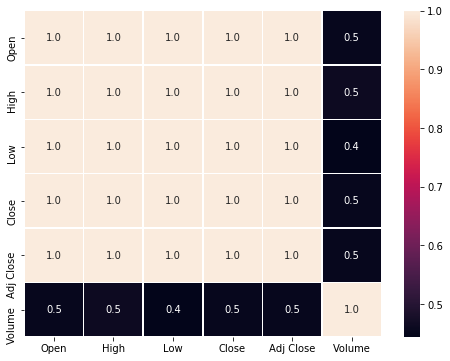

In [2]:
f,ax = plt.subplots(figsize=(8, 6))
sns.heatmap(stock_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_ylim(6, 0)
plt.show()

In the heatmap shown above, volume seems to have a relatively strong correlation with all of the other attributes

In [3]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 7 columns):
Date         2324 non-null object
Open         2324 non-null float64
High         2324 non-null float64
Low          2324 non-null float64
Close        2324 non-null float64
Adj Close    2324 non-null float64
Volume       2324 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 127.2+ KB


In [4]:
# The date is being saved as string, we need to convert that to date time so that
# pandas will be able to organize the information by time.
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.sort_values(by='Date')
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


<img src = "Avg Volume.png" width = "700">

In [5]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2.324000e+03
mean,179.103275,182.202904,175.816979,179.099368,179.099368,5.318146e+06
std,113.302123,115.044299,111.427284,113.306670,113.306670,4.659933e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,33.842498,34.487502,33.184999,33.817500,33.817500,1.761525e+06
50%,209.219993,213.149994,206.025002,208.705001,208.705001,4.414150e+06
75%,260.759995,264.497505,255.734997,260.789993,260.789993,7.130325e+06
max,386.690002,389.609985,379.350006,385.000000,385.000000,3.716390e+07


In [6]:
# We're dropping all rows with null values because replacing them with the volume mean 
# would skew the data since the range is extremely sparse 
# We only want to deal with actual values
stock_data = stock_data.dropna()

In [7]:
# Outlier is going to be a binary indication on whether the volume is 
# an outlier compared to the cumalative sum of the mean at the time its
# being calculated
stock_data['Outlier'] = 0

# Prediction is going to be an inidication on the direction we think the
# stock is going to move
# 1 means we want to buy
# 0 means hold
# -1 means we want to sell
stock_data['Prediction'] = 0

### The stochastic oscillator is calculated using the following formula:
%K = 100(C – L14)/(H14 – L14)

Where:
* C = the most recent closing price
* L14 = the low of the 14 previous trading sessions
* H14 = the highest price traded during the same 14-day period
* %K= the current market rate for the currency pair
* %D = 3-period moving average of %K

In [8]:
# Calculates Stochastic Oscillator values and adds the columns and values in the dataframe
def create_stochastic_oscillator(stock_data):
    stock_data['L14'] = stock_data['Low'].rolling(window=14).min()
    stock_data['H14'] = stock_data['High'].rolling(window=14).max()
    stock_data['%K'] = 100*((stock_data['Close'] - stock_data['L14']) / (stock_data['H14'] - stock_data['L14']))
    stock_data['%D'] = stock_data['%K'].rolling(window=3).mean()
    return stock_data
stock_data = create_stochastic_oscillator(stock_data)

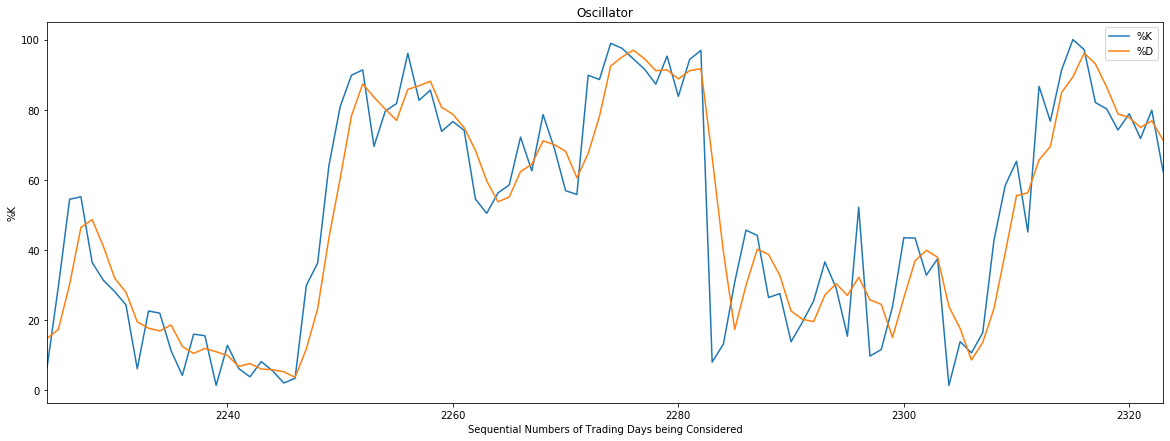

In [9]:
def draw_stochastic_oscillator(stock_data):
    fig, axes = plt.subplots(figsize=(20,7))   
    stock_data[['%K','%D']].plot(ax=axes); axes.set_title('Oscillator')
    plt.ylabel('%K')
    plt.xlabel('Sequential Numbers of Trading Days being Considered')
    plt.show()
    
# For demonstration, we're drawing the oscillator on the last 100 values
temp_stock_data = stock_data[len(stock_data)-100:]
draw_stochastic_oscillator(temp_stock_data)

In [10]:
# This function takes the %K and %D values from the stochastic oscillator and
# Writes a -1, 0, or 1 in the Position Column which lets us know it thinks
# that its time to short, hold, or long
def calculate_long_short(stock_data):   
    stock_data['Sell Entry'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)
    stock_data['Sell Exit'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) 

    stock_data['Short'] = np.nan 
    stock_data.loc[stock_data['Sell Entry'],'Short'] = -1 
    stock_data.loc[stock_data['Sell Exit'],'Short'] = 0 

    stock_data['Short'][0] = 0 
    stock_data['Short'] = stock_data['Short'].fillna(method='pad') 

    stock_data['Buy Entry'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20) 
    stock_data['Buy Exit'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) 

    stock_data['Long'] = np.nan  
    stock_data.loc[stock_data['Buy Entry'],'Long'] = 1  
    stock_data.loc[stock_data['Buy Exit'],'Long'] = 0
    
    stock_data['Long'][0] = 0  
    stock_data['Long'] = stock_data['Long'].fillna(method='pad') 
    stock_data['Position'] = stock_data['Long'] + stock_data['Short']
    
    return stock_data

stock_data = calculate_long_short(stock_data)

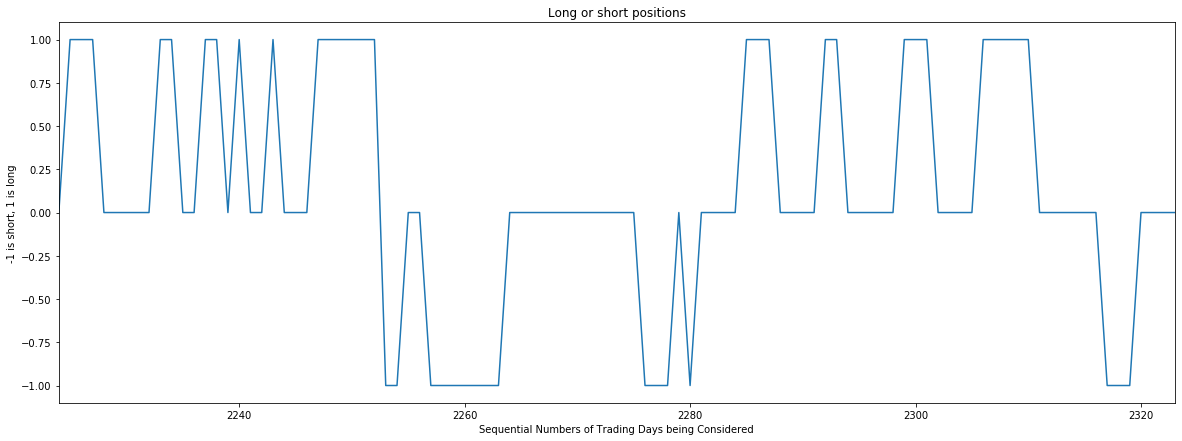

In [11]:
# Draws out the Long and Short Position Column over time
def draw_long_short(stock_data):
    stock_data['Position'].plot(figsize=(20,7))
    plt.title('Long or short positions')
    plt.ylabel('-1 is short, 1 is long')
    plt.xlabel('Sequential Numbers of Trading Days being Considered')
    plt.show()

# Again, to demonstrate the shape of the graph we're going to look at the last 100 values
temp_stock_data = stock_data[len(stock_data)-100:]
draw_long_short(temp_stock_data)

2.424984125912788 % Returns


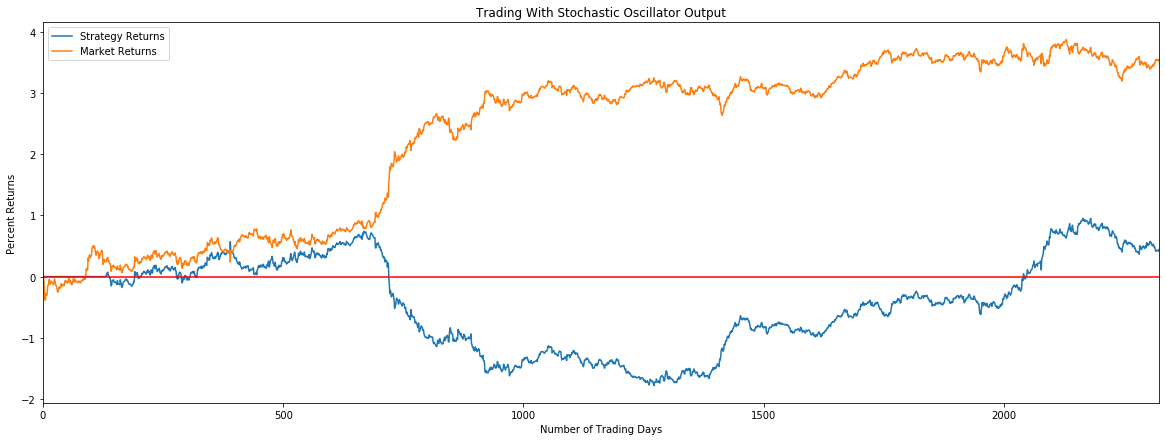

In [21]:
# This is a visual representation of what would happen if you go solely make your trades 
# based on what the long or short indicators say
def draw_strategy_vs_market_return(stock_data):
    #Set up a column holding the daily Tesla returns
    stock_data['Market Returns'] = stock_data['Close'].pct_change()

    #Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
    #of business the previous day
    stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)

    #Finally plot the strategy returns versus Apple returns
    stock_data[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20, 7))
    plt.title("Trading With Stochastic Oscillator Output")
    plt.xlabel("Number of Trading Days")
    plt.ylabel("Percent Returns")
    plt.axhline(y=0, color='r', linestyle='-')
    print(stock_data.iloc[-1]['Strategy Returns'] * 100, '% Returns')


draw_strategy_vs_market_return(stock_data)

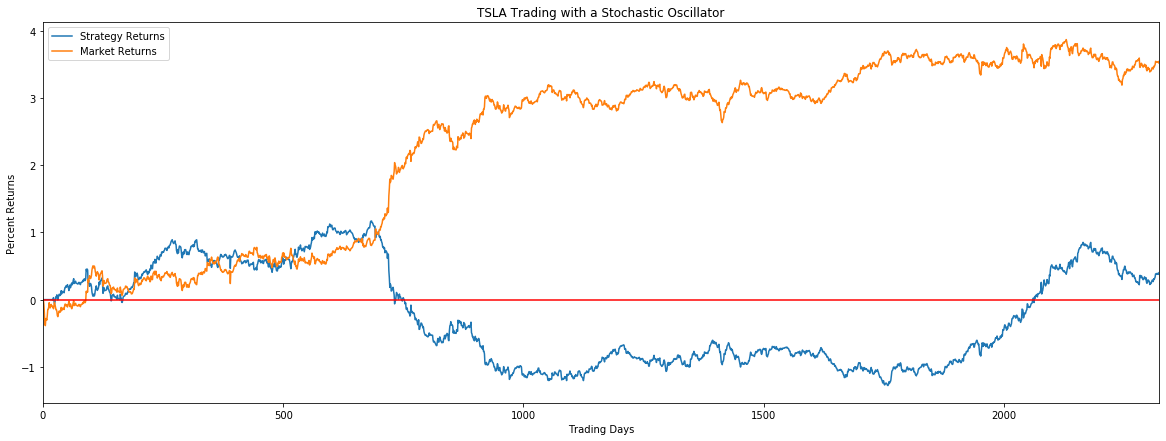

In [22]:
def draw_buy_sell_entry(stock_data):
    stock_data['Sell Entry'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)
    stock_data['Buy Entry'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20)
    #Create empty "Position" column
    stock_data['Position'] = np.nan 
    #Set position to -1 for sell signals
    stock_data.loc[stock_data['Sell Entry'],'Position'] = -1 
    #Set position to -1 for buy signals
    stock_data.loc[stock_data['Buy Entry'],'Position'] = 1 
    #Set starting position to flat (i.e. 0)
    stock_data['Position'].iloc[0] = 0 
    #Forward fill the position column to show holding of positions through time
    stock_data['Position'] = stock_data['Position'].fillna(method='ffill')
    #Set up a column holding the daily Tesla returns
    stock_data['Market Returns'] = stock_data['Close'].pct_change()
    #Create column for Strategy Returns by multiplying the daily Tesla returns by the position that was held at close
    #of business the previous day
    stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)
    #Finally plot the strategy returns versus Tesla returns
    stock_data[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,7))
    plt.title('TSLA Trading with a Stochastic Oscillator')
    plt.xlabel('Trading Days')
    plt.ylabel('Percent Returns')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()
draw_buy_sell_entry(stock_data)

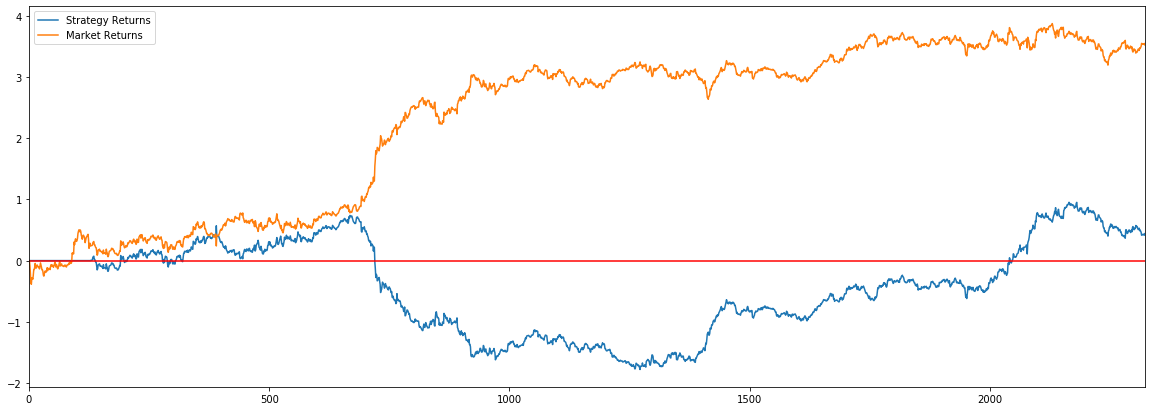

2.424984125912788 % Returns


In [25]:
def draw_predictions(stock_data):
    stock_data['Sell Entry'] = (stock_data.Prediction.shift(1) == -1)  # ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)
    stock_data['Buy Entry'] = (stock_data.Prediction.shift(1) == 1)  # ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20)
    #Create empty "Position" column
    stock_data['Position'] = np.nan 
    #Set position to -1 for sell signals
    stock_data.loc[stock_data['Sell Entry'],'Position'] = -1 
    #Set position to -1 for buy signals
    stock_data.loc[stock_data['Buy Entry'],'Position'] = 1 
    #Set starting position to flat (i.e. 0)
    stock_data['Position'].iloc[0] = 0 
    #Forward fill the position column to show holding of positions through time
    stock_data['Position'] = stock_data['Position'].fillna(method='ffill')
    #Set up a column holding the daily Apple returns
    stock_data['Market Returns'] = stock_data['Close'].pct_change()
    #Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
    #of business the previous day
    stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)
    #Finally plot the strategy returns versus Apple returns
    stock_data[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,7))
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()
    print(stock_data.iloc[-1]['Strategy Returns'] * 100, '% Returns')

draw_predictions(stock_data)

In [15]:
def make_predictions(stock_data):
    list_vol_avg = [stock_data.iloc[99].Volume]
    vol_avg = int(np.mean(stock_data.iloc[:100].Volume))
    for i in range(100, len(stock_data)):
        q1 = np.percentile(stock_data.iloc[:i].Volume, 25)
        q3 = np.percentile(stock_data.iloc[:i].Volume, 75)
        iqr = (q3 - q1) * 1.1
        if (stock_data.iloc[i].Volume < q1 - iqr) or (stock_data.iloc[i].Volume > q3 + iqr):
            stock_data.set_value(i, 'Outlier', 1)
            
            
        if (stock_data.iloc[i].Outlier == 1 and stock_data.iloc[i].Long == 1):
            #stock_data.iloc[i].Prediction = 1
            stock_data.set_value(i, 'Prediction', 1)
            
        if (stock_data.iloc[i].Outlier == 1 and stock_data.iloc[i].Short == -1):
            #stock_data.iloc[i].Prediction = -1
            stock_data.set_value(i, 'Prediction', -1)
            
        vol_avg = int(np.mean(stock_data.iloc[:i].Volume))
        list_vol_avg.append(vol_avg)
    return stock_data

In [16]:
def main():
    stock_data = pd.read_csv(os.getcwd() + "/Stock_Data/TSLA.csv")
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.sort_values(by='Date')
    stock_data = stock_data.dropna()
    
    stock_data['Outlier'] = 0
    stock_data['Prediction'] = 0
    stock_data = create_stochastic_oscillator(stock_data)
    stock_data = calculate_long_short(stock_data)
    stock_data = make_predictions(stock_data)
    stock_data.to_csv('TSLA_Stochastic_Oscillator_Dataframe.csv')
    return stock_data
    
stock_data = main()

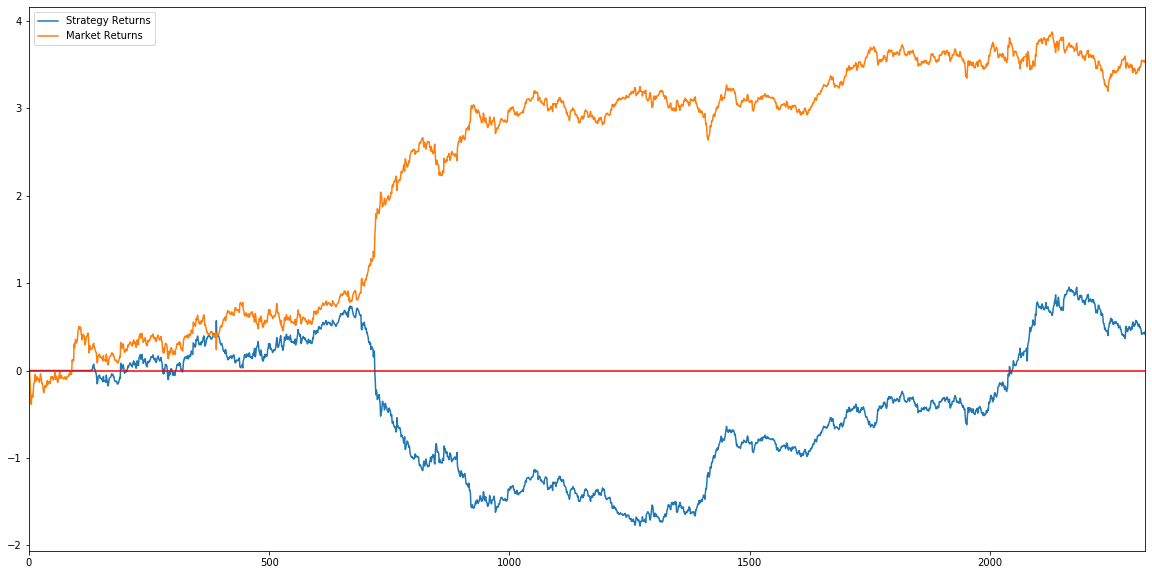

Strategy 0.02424984125912788
Market -0.02424984125912788


In [17]:
draw_predictions(stock_data)

In [18]:
stock_data.corr()

,Open,High,Low,Close,Adj Close,Volume,Outlier,Prediction,L14,H14,...,%D,Sell Entry,Sell Exit,Short,Buy Entry,Buy Exit,Long,Position,Market Returns,Strategy Returns
Open,1.000000,0.999569,0.999550,0.999019,0.999019,0.453993,-0.064232,0.033178,0.993125,0.994019,...,0.039395,-0.035292,-0.009952,-0.051022,0.014515,0.014719,0.040617,0.013316,-0.033572,0.025940
High,0.999569,1.000000,0.999480,0.999616,0.999616,0.462806,-0.058355,0.034431,0.992620,0.994328,...,0.040777,-0.033944,-0.003355,-0.047056,0.016978,0.010119,0.044306,0.013018,-0.019365,0.027923
Low,0.999550,0.999480,1.000000,0.999569,0.999569,0.444386,-0.071070,0.035068,0.993023,0.993126,...,0.044436,-0.036978,-0.005050,-0.048448,0.013719,0.009051,0.042597,0.016147,-0.019319,0.026425
Close,0.999019,0.999616,0.999569,1.000000,1.000000,0.453934,-0.064419,0.037944,0.992556,0.993614,...,0.043606,-0.034851,0.002530,-0.042998,0.016075,0.002548,0.047882,0.015016,-0.005273,0.029511
Adj Close,0.999019,0.999616,0.999569,1.000000,1.000000,0.453934,-0.064419,0.037944,0.992556,0.993614,...,0.043606,-0.034851,0.002530,-0.042998,0.016075,0.002548,0.047882,0.015016,-0.005273,0.029511
Volume,0.453993,0.462806,0.444386,0.453934,0.453934,1.000000,0.597003,-0.048880,0.436509,0.485707,...,-0.003377,0.212047,0.018509,-0.011640,0.158625,0.022107,0.038694,-0.123002,0.016435,-0.018531
Outlier,-0.064232,-0.058355,-0.071070,-0.064419,-0.064419,0.597003,1.000000,-0.118484,-0.093141,-0.054096,...,0.076407,0.310548,0.039935,-0.005422,0.139293,0.004434,-0.047223,-0.252527,0.060153,-0.045148
Prediction,0.033178,0.034431,0.035068,0.037944,0.037944,-0.048880,-0.118484,1.000000,0.058259,0.055115,...,-0.227906,-0.308612,0.103664,0.333687,0.243254,-0.138172,0.268583,0.180421,0.149316,0.038300
L14,0.993125,0.992620,0.993023,0.992556,0.992556,0.436509,-0.093141,0.058259,1.000000,0.993138,...,-0.036022,-0.060896,-0.003461,-0.012685,0.014652,-0.002288,0.060452,0.033013,-0.044447,0.027942
H14,0.994019,0.994328,0.993126,0.993614,0.993614,0.485707,-0.054096,0.055115,0.993138,1.000000,...,-0.036713,-0.040241,-0.001816,-0.016963,0.036240,-0.000232,0.074999,0.016641,-0.040668,0.028342
